# Tensorflow CNN model for alphanumeric CAPTCHAs
### Notebook to build a Convolutional Neural Network (CNN) model capable of decoding alphanumeric CAPTCHAs of varying lengths and without considering case sensitivity.

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import datetime
import random

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras import optimizers, losses, layers
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.optimizers.legacy import RMSprop

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input


## 1. Load image dataset 

Nb of files in folder: 104687 

Example Image: hkwx7t.jpg
Image has shape: (70, 200, 3)
The maximum pixel value used is: 255.0


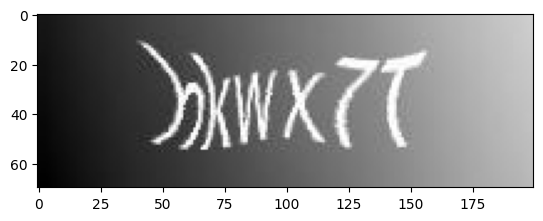

In [3]:
# Dataset directory
######################################
base_dir = "./build_dataset/dataset/"
######################################

list_dir = os.listdir(base_dir)
print(f"Nb of files in folder: {len(list_dir)} \n")

# select Random image
random_i = random.randint(0, len(list_dir)-1)
print("Example Image: %s" % os.listdir(base_dir)[random_i])

# Load the Random image
source_image  = load_img(f"{os.path.join(base_dir, list_dir[random_i])}")
# Convert the image into its numpy array representation
source_array = img_to_array(source_image)
print(f"Image has shape: {source_array.shape}")
print(f"The maximum pixel value used is: {np.max(source_array)}")

# Show the Random image
plt.imshow(load_img(f"{os.path.join(base_dir, list_dir[random_i])}"))
plt.show()


## 2. Generate input data for the model

In [4]:
images_array, labels = [],[]
list_dir = os.listdir(base_dir)
p = np.random.permutation(len(list_dir))

# Randomize file order
list_dir_new = list_dir
for i,j in enumerate(p):
    list_dir_new[i] = list_dir[j]

# Load files and labels (=file name)
for i,file_image in enumerate(list_dir_new):
    # filter on images
    if (("jpg" in file_image or "jpeg" in file_image or "png" in file_image) and os.path.getsize(os.path.join(base_dir, file_image)) > 0):

        image = load_img(f"{os.path.join(base_dir, file_image)}", color_mode = "grayscale") 
        images_array.append( img_to_array(image) ) # Converts a PIL Image instance to a Numpy array.

        labels.append( file_image.split(".")[0] ) # Extract the image label (= fila name without extension)

x_train = images_array
y_train = labels


# We normalize all label lengths to the same size
max_label_len = max(len(label) for label in y_train)
print("Max label length: ", max_label_len)
for i,y in enumerate(y_train):
    diff = max_label_len - len(y)
    for j in range(diff):
        y_train[i] += ' ' 
        
    
# We identify all the possible characters of the CAPTCHA
characters = set(char for label in y_train for char in label)
characters = sorted(list(characters))
print("CAPTCHA characters to predict: ", characters)


# Dictionnaries to map characters to integers
char_to_num = {}
for i,char in enumerate(characters):
    char_to_num[char] = i

num_to_char = {}
for i,char in enumerate(characters):
    num_to_char[i] = char

    
x_train_num = np.array(x_train) # convert to numpy array


y_train_num = []
for y_train_i in y_train:
 
    y_train_new_i = []
    for j in range(max_label_len): #
        # Convert to vector format
        if j < len(y_train_i):
            y_train_new_i.append( to_categorical(char_to_num[y_train_i[j]], num_classes = len(characters), dtype ="int32") ) 
        else:
            y_train_new_i.append(np.zeros(len(characters), dtype=int))
    y_train_num.append(y_train_new_i)
y_train_num =  np.array(y_train_num) # convert to numpy array

#Display one image to check
#check =  y_train[5].strip() + ".jpg"
#plt.imshow(load_img(f"{os.path.join(base_dir, check)}"))
#plt.show()


print("X train shape (images): ", x_train_num.shape)
print("Y train shape (labels): ", y_train_num.shape)

# Reshape label vectors to single dimension
a,b,c = y_train_num.shape
y_train_num = y_train_num.reshape(a,b*c)
print("Y train reshaped: ", y_train_num.shape)


Max label length:  7
CAPTCHA characters to predict:  [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
X train shape (images):  (104687, 70, 200, 1)
Y train shape (labels):  (104687, 7, 37)
Y train reshaped:  (104687, 259)



# 3. Augment data


In [5]:
#########################
VALIDATION_SPLIT = 0.005
#########################


# Data Augmentation (uncomment below when the dataset is too small)
train_datagen = ImageDataGenerator(rescale = 1./255.
                                   #   , rotation_range = 4
                                   #   , width_shift_range =  0.02 # it's actually heigh in our case
                                   #   , height_shift_range = 0.08 # it's actually width in our case
                                   #   , shear_range = 10  
                                   #   , zoom_range = 0.08 
                                   , validation_split = VALIDATION_SPLIT
                             )

# No augmentation on test data https://github.com/keras-team/keras/issues/5862#issuecomment-647559571
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
   , validation_split=VALIDATION_SPLIT
)    

train_generator = train_datagen.flow((x_train_num,  y_train_num)
                                     #, seed=42
                                     #,  shuffle=True
                                     , batch_size=256
                                     , subset='training'
                                     #, save_to_dir='./augmentation/'
                                    )

test_generator = test_datagen.flow((x_train_num , y_train_num)
                                   #, seed=42
                                   #, shuffle=True
                                   , batch_size=16
                                   , subset='validation'
                                   )


## 4. Train model

In [5]:
##############
EPOCHS = 20
##############

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') is not None and logs.get('accuracy') > 0.60) and( logs.get('val_accuracy') is not None and logs.get('val_accuracy') >= 0.85):
            print("\nReached 60% accuracy and val_accuracy > 85% so stopping training!")
            self.model.stop_training = True    

            
# Instantiate the callback
callbacks = myCallback()


input_layer = Input((70, 200, 1))
x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
#x = MaxPooling2D(pool_size=(2, 2))(x)
#x = Dropout(0.3)(x)
x = Flatten()(x)
#x = Dense(1024, activation='relu')(x)
#x = Dropout(0.3)(x)
#x = Dense(435, activation='relu')(x) 
#x = Dropout(0.3)(x)

#out = [Dense(len(characters), name='digit%d' % i, activation='softmax')(x) for i in range(max_label_len)]
out = Dense(len(characters)*max_label_len, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=out)



# Compile the model
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])     

print(model.summary())


# Train the model
history = model.fit( train_generator
                    , validation_data=test_generator
                    , epochs=EPOCHS
                    , callbacks=[callbacks]
                    , verbose=2
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70, 200, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 70, 200, 32)       832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 35, 100, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 100, 48)       38448     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 17, 50, 48)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 50, 64)        76864 

2023-08-27 11:58:30.165347: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-27 12:12:24.983667: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


407/407 - 836s - loss: 0.1029 - accuracy: 0.0098 - val_loss: 0.0560 - val_accuracy: 0.0918 - 836s/epoch - 2s/step
Epoch 2/20
407/407 - 884s - loss: 0.0287 - accuracy: 0.1832 - val_loss: 0.0120 - val_accuracy: 0.3212 - 884s/epoch - 2s/step
Epoch 3/20
407/407 - 863s - loss: 0.0092 - accuracy: 0.2655 - val_loss: 0.0061 - val_accuracy: 0.2772 - 863s/epoch - 2s/step
Epoch 4/20
407/407 - 872s - loss: 0.0047 - accuracy: 0.2555 - val_loss: 0.0035 - val_accuracy: 0.2314 - 872s/epoch - 2s/step
Epoch 5/20
407/407 - 890s - loss: 0.0028 - accuracy: 0.2229 - val_loss: 0.0022 - val_accuracy: 0.1453 - 890s/epoch - 2s/step
Epoch 6/20
407/407 - 886s - loss: 0.0019 - accuracy: 0.1794 - val_loss: 0.0016 - val_accuracy: 0.1319 - 886s/epoch - 2s/step
Epoch 7/20
407/407 - 888s - loss: 0.0012 - accuracy: 0.1472 - val_loss: 0.0011 - val_accuracy: 0.1300 - 888s/epoch - 2s/step
Epoch 8/20
407/407 - 877s - loss: 9.3297e-04 - accuracy: 0.1194 - val_loss: 9.6084e-04 - val_accuracy: 0.1071 - 877s/epoch - 2s/step
Epo


## 5. Plot the results for both the training and test data

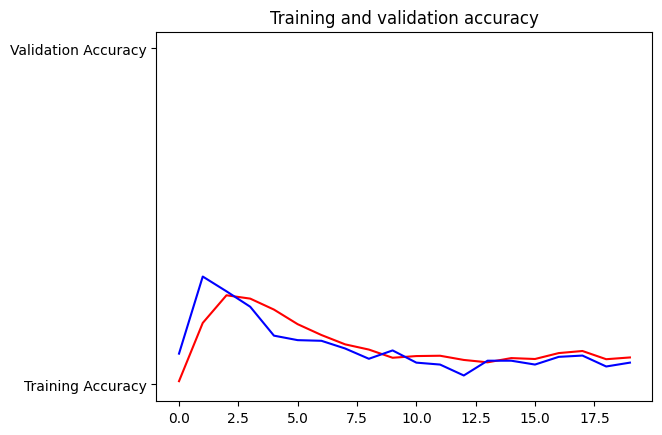

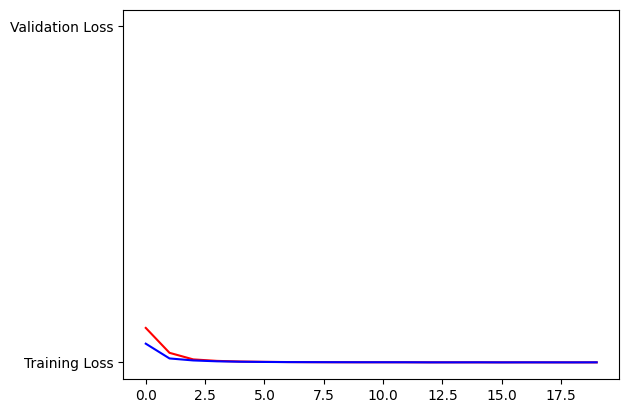

In [6]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

## 6. Check the predictions for a few images

In [11]:
check_files = [list_dir_new[0], list_dir_new[1], list_dir_new[2], list_dir_new[3]]

for file_i in check_files:
    test_image  = load_img(base_dir + file_i, color_mode = "grayscale")
    test_array = img_to_array(test_image)  # Converts a PIL Image instance to a Numpy array.
    test_array /=  255.0 # Convert to decimal value
    test_array = np.expand_dims(test_array, axis=0) # add a dimension
    result = model.predict(test_array)
    result = result.reshape(1, max_label_len, len(characters)) # reshape predicted label to multi verctor dimensions
    print(f"\n{file_i}")
    print("Predicted shape: %s" % str(test_array.shape))
    text = ""
    text_check = "Char. scores: "
    text_score = 1
    for i in range(max_label_len):
        text += num_to_char[np.argmax(result[0][i])] # retrieve the position of the biggest predicted value for each vector
        text_check += str(round(result[0][i][np.argmax(result[0][i])], 2)) + " " 
        text_score *= result[0][i][np.argmax(result[0][i])]
    text = text.strip() # remove end spaces
    print(text)
    print("Total score : {:.1%}".format(text_score))
    print(text_check)

1/1 [==============================] - 0s 98ms/step

6madmo.jpg
Predicted shape: (1, 70, 200, 1)
6madmo
Total score : 99.8%
Char. scores: 1.0 1.0 1.0 1.0 1.0 1.0 1.0 
1/1 [==============================] - 0s 13ms/step

x3dspk.jpg
Predicted shape: (1, 70, 200, 1)
x3dspk
Total score : 100.0%
Char. scores: 1.0 1.0 1.0 1.0 1.0 1.0 1.0 
1/1 [==============================] - 0s 12ms/step

sbxlzs.jpg
Predicted shape: (1, 70, 200, 1)
sbxlzs
Total score : 100.0%
Char. scores: 1.0 1.0 1.0 1.0 1.0 1.0 1.0 
1/1 [==============================] - 0s 12ms/step

gtglaf.jpg
Predicted shape: (1, 70, 200, 1)
gtglaf
Total score : 0.2%
Char. scores: 1.0 0.0 1.0 1.0 1.0 1.0 1.0 



## 6. Save model

In [8]:
save_dir = "./models/"

def save_history():
  today = datetime.datetime.today() 
  today_str = today.strftime('%Y-%m-%d_%Hh%M')
  file_name = save_dir + 'model_%s.pkl' % today_str
    
  model.save(file_name)
    
save_history()

INFO:tensorflow:Assets written to: ./models/model_2023-08-27_16h54.pkl/assets


INFO:tensorflow:Assets written to: ./models/model_2023-08-27_16h54.pkl/assets



## 7. Evaluate the model on the whole dataset

In [9]:

results = model.evaluate(x_train_num, y_train_num, batch_size=128)
print("test loss, test accuracy:", results)


818/818 [==============================] - 266s 325ms/step - loss: 16.5286 - accuracy: 0.3588
test loss, test accuracy: [16.52863121032715, 0.35879334807395935]
